In [2]:
from __future__ import print_function
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [18]:
dataroot = "D:/DATA_SCIENCE/celeba"
workers = 2
batch_size = 128
image_size = 64
nc = 3 #the number of channels
nz = 100 #the size of generator input
ngf = 64 #size of feature maps in generator
ndf = 64 #size of feature maps in discriminator
num_epochs = 1
lr = 0.0002
beta1 = 0.5
ngpu = 1


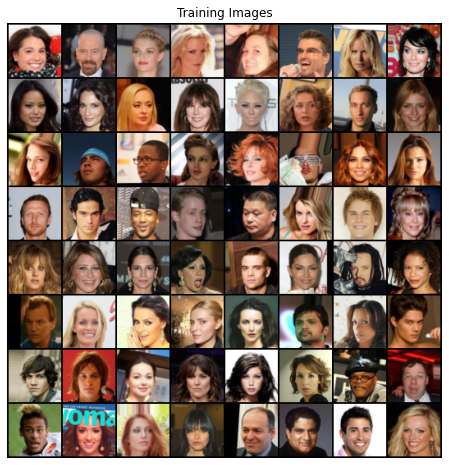

In [19]:
dataset = dset.ImageFolder(root = dataroot,
                          transform = transforms.Compose([
                              transforms.Resize(image_size),
                              transforms.CenterCrop(image_size),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                          ]))

dataloader = torch.utils.data.DataLoader(dataset = dataset, batch_size = batch_size, shuffle = True, num_workers = workers)
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else 'cpu')

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [8]:
device #we have cuda available

device(type='cuda', index=0)

In [9]:
def weights_init(m): #the DCGAN paper, the authors specifies that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02.
    #classname = m.__class__.__name__
    print(classname)
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [11]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False), #input, output, kernel, stride, padding
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
        
    def forward(self, input):
        return self.main(input)

In [13]:
netG = Generator(ngpu).to(device)

netG.apply(weights_init)
netG

ConvTranspose2d
BatchNorm2d
ReLU
ConvTranspose2d
BatchNorm2d
ReLU
ConvTranspose2d
BatchNorm2d
ReLU
ConvTranspose2d
BatchNorm2d
ReLU
ConvTranspose2d
Tanh
Sequential
Generator


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [14]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [15]:
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

netD

Conv2d
LeakyReLU
Conv2d
BatchNorm2d
LeakyReLU
Conv2d
BatchNorm2d
LeakyReLU
Conv2d
BatchNorm2d
LeakyReLU
Conv2d
Sigmoid
Sequential
Discriminator


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [17]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, nz, 1, 1, device = device) #to visualize the progress of the generator

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        optimizerD.step()
        
        
        netG.zero_grad()
        label.fill_(real_label)

        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

[0/1][0/1583]	Loss_D: 1.7674	Loss_G: 5.1556	D(x): 0.5655	D(G(z)): 0.5878 / 0.0097
[0/1][50/1583]	Loss_D: 1.1750	Loss_G: 1.2702	D(x): 0.9030	D(G(z)): 0.6385 / 0.3136
[0/1][100/1583]	Loss_D: 7.0925	Loss_G: 0.2304	D(x): 0.2249	D(G(z)): 0.9034 / 0.8026
[0/1][150/1583]	Loss_D: 10.0189	Loss_G: 0.1501	D(x): 0.0159	D(G(z)): 0.9457 / 0.8669
[0/1][200/1583]	Loss_D: 7.7516	Loss_G: 0.1151	D(x): 0.1577	D(G(z)): 0.9763 / 0.8960
[0/1][250/1583]	Loss_D: 9.8908	Loss_G: 0.0332	D(x): 0.2108	D(G(z)): 0.9909 / 0.9678
[0/1][300/1583]	Loss_D: 19.2565	Loss_G: 12.0447	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[0/1][350/1583]	Loss_D: 8.0119	Loss_G: 0.0518	D(x): 0.3031	D(G(z)): 0.9750 / 0.9505
[0/1][400/1583]	Loss_D: 18.1999	Loss_G: 0.0351	D(x): 0.0099	D(G(z)): 0.9866 / 0.9665
[0/1][450/1583]	Loss_D: 25.4289	Loss_G: 0.0653	D(x): 0.0017	D(G(z)): 0.9819 / 0.9415
[0/1][500/1583]	Loss_D: 30.6452	Loss_G: 0.1951	D(x): 0.0004	D(G(z)): 0.9001 / 0.8440
[0/1][550/1583]	Loss_D: 39.1642	Loss_G: 11.8349	D(x): 0.1029	D(G(z)): 0.8